# ID2222 Data Mining - Homework 1

Notebook by Beatrice Insalata, Laura Puccioni

For this task, we are asked to implement the stages of finding textually similar documents based on Jaccard similarity by using the *shingling, minhashing and locality-sensitive hashing (LSH) techniques*. We have used the Python language to examine and score similarity among 10 documents.

In [92]:
import pandas as pd
import numpy as np
import random
from random import shuffle
import re
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from math import ceil
from itertools import combinations
import time

## Dataset
Our dataset consists in a set of IELTS Writing Scored Essays, from Kaggle: [link](https://www.kaggle.com/datasets/mazlumi/ielts-writing-scored-essays-dataset). The "IELTS Writing Scored Essays Dataset" is an extensive collection of over 1200 essays, and its text-based content allows for extensive analyses fitting for our purpose.

In [2]:
df = pd.read_csv('ielts_writing_dataset.csv')
df.drop(df.columns[3:7 + 1], axis=1, inplace=True)
df = df.head(10)
df

,Task_Type,Question,Essay,Overall
0,1,The bar chart below describes some changes abo...,"Between 1995 and 2010, a study was conducted r...",5.5
1,2,Rich countries often give money to poorer coun...,Poverty represents a worldwide crisis. It is t...,6.5
2,1,The bar chart below describes some changes abo...,The left chart shows the population change hap...,5.0
3,2,Rich countries often give money to poorer coun...,Human beings are facing many challenges nowada...,5.5
4,1,The graph below shows the number of overseas v...,Information about the thousands of visits from...,7.0
5,2,Some countries achieve international sports by...,Whether countries should only invest facilitie...,6.5
6,1,The graph below shows the number of overseas v...,This graph depicts the changes in tourists vis...,6.5
7,2,Some countries achieve international sports by...,"Sports is an essential part to most of us , so...",5.5
8,1,The graph below shows the number of overseas v...,The line graph illustrates the number of overs...,8.0
9,2,Some countries achieve international sports by...,International sports events require the most w...,9.0


The 'Essay' column contains the data we will use for comparison. We can examine the content of a single essay.

In [3]:
text = df.loc[0, 'Essay']
text

'Between 1995 and 2010, a study was conducted representing the percentages of people born in Australia, versus people born outside Australia, living in urban, rural, and town. First, in 1995, cities represented the major percentage of habitat by roughly 50 percent, followed by rural areas and towns came in last, among people born in Australia. On the other hand, people born outside Australia, cities showed the most percentages of 6o percent, followed by rural areas and towns. In 2010, among people born in Australia, cities had an increase more than 20 percent increase in the total representation and a major decrease in towns and rural areas. Conversely, people born outside Australia, cities had the most percentage among both studies, followed by rural areas and towns.'

## Shingling
The first step is implementing a class Shingling that constructs k–shingles of a given length k (e.g., 10) from a given document, computes a hash value for each unique shingle and represents the document in the form of an ordered set of its hashed k-shingles.

The first method builds the shingles from the raw Essay text, with a default k-value equal to 5 diven the short length of the text.

The second method uses the Python function 'hash()' to get an integer value from the text, and considers a hashing scope of (2**32)-1, which corresponds to an int.

In [4]:
class Shingling:

# Method to build k-shingle of single document
  def build_shingle(self, doc, k=5):
    shingles = []
    for i in range(len(doc)-k+1):
      shingles.append(doc[i:i+k])
    return set(shingles)

# Method for building a hashed k-shingle
  def build_hash(self, text, k=5, hashing = ((2**32)-1)):
    hashed = []
    shingles = self.build_shingle(text, k)
    for shingle in shingles:
      hashed.append(hash(shingle) % hashing)
    return set(hashed)


We can visualize how a shingle set looks by inputting a sentence from the first Essay:

In [5]:
# Building a shingler and applying function

shingler = Shingling()

sentence = 'in Australia'

set_1 = shingler.build_shingle(sentence, 5)
set_1

{' Aust', 'Austr', 'in Au', 'n Aus', 'ralia', 'stral', 'trali', 'ustra'}

The sentence has been successfully split into k-shingles of length 5. Having the shingles, we can also build a hash for them, allowing better storage capacities and easier access, as well as more immediate comparison. We can visualize the hashing of the previous sentence:

In [6]:
hashed = shingler.build_hash(sentence, 5)
print(hashed)

{3257780067, 2134514345, 2599753744, 2821727539, 674197338, 2691435292, 454697725, 3397513534}


These numbers each represent one shingle. K-hashing represents a useful methodology for comparison. Since the hashing has the consistency property (meaning two shingles will have the same hashing), we can see how two texts are close by consulting their hashings. This can be done by doing the 'and' operation to see which hash match.

In [7]:
other_sentence = 'outside Australia'
set_2 = shingler.build_shingle(other_sentence)
hashed_2 = shingler.build_hash(other_sentence)
print(hashed_2)

{3257780067, 549883175, 3354810618, 4266779917, 2101325454, 2599753744, 2821727539, 3605427254, 126380120, 674197338, 454697725, 3397513534, 1725106079}


In [8]:
exp=[i for i in hashed if i in hashed_2]

print(f'The two sentences have the following hashes in common:{exp}')

The two sentences have the following hashes in common:[3257780067, 2599753744, 2821727539, 674197338, 454697725, 3397513534]


This result is coherent with both the hashing comparison and the fact that both strings included very similar words.

# Jaccard Similarity

Given the numerical representation, we can exploit the Jaccard similarity to compute how close two sets of hashed k-shingles are. The Jaccard similarity is defined as: 𝙹(A,B) = |A ∩ B|/|A ∪ B|

This means that the size of the intersection is divided by the size of the union to see how much overlapping the two sets have.
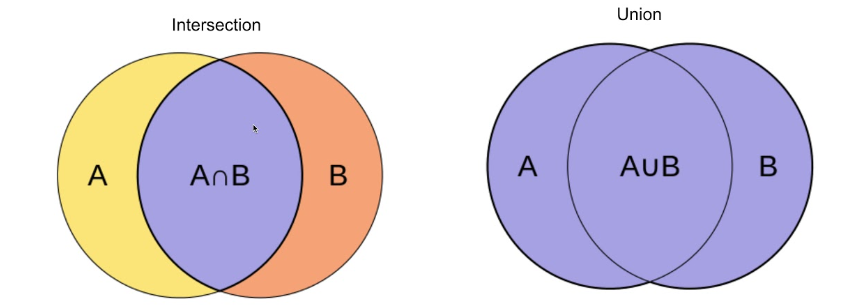

In [9]:
class CompareSets:

# Method to compute the Jaccard similarity of two sets

  def jaccard_sim(self, set_a, set_b):
    intersection = set_a & set_b
    union = set_a | set_b

    similarity = len(intersection)/(len(union))
    return similarity

# Method to compute the Jaccard distance of two sets

  def jaccard_dist(self, set_a, set_b):

    return 1-self.jaccard_sim(set_a, set_b)


In [10]:
comparer = CompareSets()
sim = comparer.jaccard_sim(hashed, hashed_2)
print(f'The Jaccard similarity for the two hashed k-shingles is: {sim}')

The Jaccard similarity for the two hashed k-shingles is: 0.4


We can check that the result is correct: 6 common values over 15 distinct numbers in total → 6/14 = 0.4

Another measure used for comparing two sets is the Jaccard distance. It is defined as the inverse of the Jaccard similarity, and indicates how different the documents are. We can easily see that this result is coherent.

In [11]:
dist = comparer.jaccard_dist(hashed, hashed_2)
print(f'The Jaccard distance for the two hashed k-shingles is: {dist}')

The Jaccard distance for the two hashed k-shingles is: 0.6


## Jaccard Similarity of Dataset
Given this powerful scoring method, we can now compute and visualize the Jaccard similarity among all documents in the set, and see how their similarity compares. All the essays are first hashed and then scored to visualize which pairs have the highest number of common k-shingles (k defaults at 5).

As an example, we can compute a single pair similarity and check if the result is coherent.

In [12]:
# Hashing two essays and computing the Jaccard similarity

hashed_essay_1 = shingler.build_hash(df.loc[0, 'Essay'])

hashed_essay_2 = shingler.build_hash(df.loc[1, 'Essay'])

sim = comparer.jaccard_sim(hashed_essay_1, hashed_essay_2)
print(f'The Jaccard similarity for the two hashed k-shingles is: {sim}')

The Jaccard similarity for the two hashed k-shingles is: 0.03836317135549872


Now, we can apply this procedure to the whole 'Essay' column of the dataframe. A heatmap is used to visualize the pairs that have the most common hashed shingles. The identity pairs were left out to not influence the granularity of the analysis.

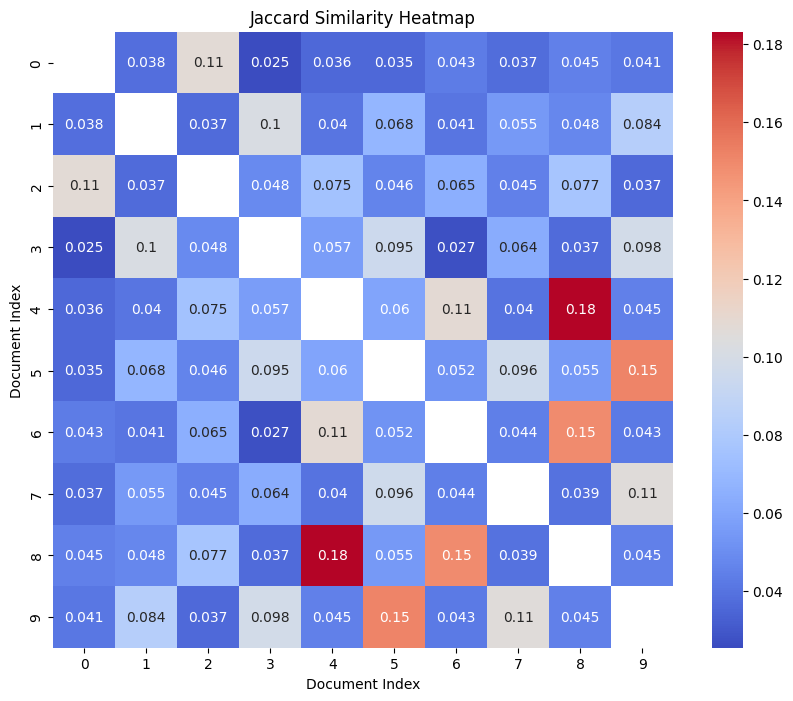

In [13]:
# Computing hashed shingles for each document

hashed_docs = [shingler.build_hash(doc) for doc in df['Essay']]

# Calculating Jaccard similarity for each pair of documents

similarity_matrix = np.zeros((len(hashed_docs), len(hashed_docs)))

for i in range(len(hashed_docs)):
    for j in range(i+1, len(hashed_docs)):
        similarity = comparer.jaccard_sim(hashed_docs[i], hashed_docs[j])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity

# Visualizing in a heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', mask=similarity_matrix == 0)
plt.title('Jaccard Similarity Heatmap')
plt.xlabel('Document Index')
plt.ylabel('Document Index')
plt.show()

We can also visualize some indicators like the maximum similarity score, minimum and average similarity value. These indicators are reasonable, since the 10 essays taken into consideration may be quite diverse both in scope and in topic, remaining quite distinct.

In [14]:
# Masking the diagonal and one half (symmetry)
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

flat_similarity = similarity_matrix[~mask]

# Computing max, min, and average excluding the diagonal and one half

max_similarity = np.max(flat_similarity)
min_similarity = np.min(flat_similarity)
avg_similarity = np.mean(flat_similarity)

print(f"Maximum similarity: {max_similarity}")
print(f"Minimum similarity: {min_similarity}")
print(f"Average similarity: {avg_similarity}")


Maximum similarity: 0.18319327731092436
Minimum similarity: 0.025495750708215296
Average similarity: 0.06377225922288127


Now we can check how the similarity will be affected by modifying the value of k from 5 to 2.

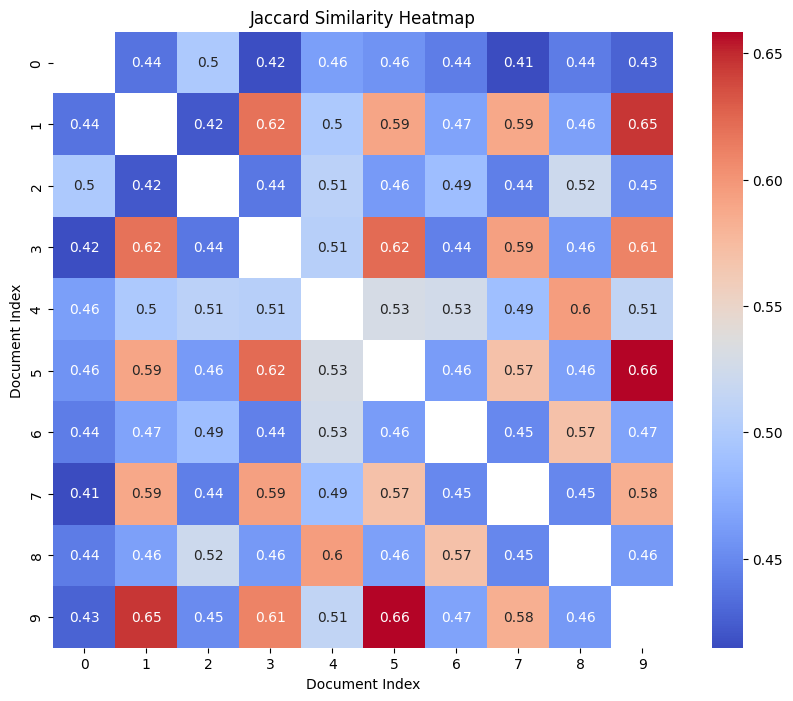

In [15]:
# Computing hashed shingles for each document
hashed_docs = [shingler.build_hash(doc, k=2) for doc in df['Essay']]

# Calculating Jaccard similarity for each pair of documents
similarity_matrix = np.zeros((len(hashed_docs), len(hashed_docs)))

for i in range(len(hashed_docs)):
    for j in range(i+1, len(hashed_docs)):
        similarity = comparer.jaccard_sim(hashed_docs[i], hashed_docs[j])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity

# Visualizing in a heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', mask=similarity_matrix == 0)
plt.title('Jaccard Similarity Heatmap')
plt.xlabel('Document Index')
plt.ylabel('Document Index')
plt.show()

As expected, the similarity scores have largely increased. Moreover, the max value of similarity is represented by another pair compared to the last one.

In [16]:
# Masking the diagonal and one half (e.g., lower triangle including diagonal)
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

# Flattening the matrix and filter out masked elements
flat_similarity = similarity_matrix[~mask]

# Computing max, min, and average excluding the diagonal and one half
max_similarity = np.max(flat_similarity)
min_similarity = np.min(flat_similarity)
avg_similarity = np.mean(flat_similarity)

print(f"Maximum similarity: {max_similarity}")
print(f"Minimum similarity: {min_similarity}")
print(f"Average similarity: {avg_similarity}")

Maximum similarity: 0.6585365853658537
Minimum similarity: 0.41479099678456594
Average similarity: 0.5028544256251132


We can take a look at the essay with index 5 and 9 to check how close they are. In fact, they both discuss similar topics and use numerous common terms. However, a higher value of k can find better balance and avoid scoring deceptively high similarity measurements.

In [17]:
print(df.loc[5, 'Essay'])
print('\n')
print(df.loc[9, 'Essay'])

Whether countries should only invest facilities and training on their elite athletes in order to win international competitions or give the same opportunities for all remains a big discussion. In this essay I will explain both views and why I think participation for all is the way which brings positive consequences.
Those supporting the first view believe that the odds to win are only high if the countries invest specialised facilities on their top sportmen. This is because, only athletes trained to reach the highest performance guarantee high scores. For example, it is known that China sends only its elite sportmen to compete in the Olympics and statistically, they usually win numbers of medals.
On the other hand, those who support sports facilities and training for all athletes consider that non-top ones can also have great opportunities to succeed. For instance, Diego Maradona, a Argentinian soccer player, never played in a professional field, on the contrary, he was discovered play

## MinHashing

Next, we can define a class MinHashing that builds a minHash signature (in the form of a vector or a set) of a given length n from a given set of integers (a set of hashed shingles).
The results are showed on sentence extracts for simplicity, intuitiveness and better visualization.

In [18]:
class MinHashing:

  # Method to build the k-shingle vocabulary

  def build_vocabulary(self, docs, k=5):
    all_sets = []
    for i in range(len(docs)):
      for j in range(len(docs[i])):
        #if not docs[i][j:j+k] in all_sets:
          all_sets.append(docs[i][j:j+k])

    return set(all_sets)

  # Method to build characteristic matrix from a list of shingles

  def generate_characteristic_matrix(self, shingle_sets):

    combined_shingles = set()
    for shingle_set in shingle_sets:
        combined_shingles.update(shingle_set)

    characteristic_matrix = []
    for shingle in combined_shingles:
        matrix_row = [int(shingle in each_set) for each_set in shingle_sets]
        characteristic_matrix.append(matrix_row)

    return np.array(characteristic_matrix)

# Method to generate minhashing signature from hashed k-shingles

  def generate_minhash_signature(self, shingle_sets, n=150, max_val=2**16-1):

        # Using a prime number larger than max_val
        large_prime = 4294967311

        # Generating random coefficients for the hash functions
        random_a_values = np.random.randint(1, max_val, size=n)
        random_b_values = np.random.randint(0, max_val, size=n)

        # Building the MinHash signature matrix
        minhash_signature_matrix = np.array([
            [np.min([(random_a_values[hash_index] * shingle + random_b_values[hash_index]) % large_prime for shingle in each_set])
             for each_set in shingle_sets]
            for hash_index in range(n)
        ])

        return minhash_signature_matrix


We can see with the follwing example how the original sentences extracted from the first essay have been one-hot encoded to indicate what shingles they include (on rows), and represented with column vectors.

In [19]:
# Collecting shingle sets into a list

shingles = [set_1, set_2]

all_shingles_union = set()
for shingle_set in shingles:
    all_shingles_union.update(shingle_set)

min_hash_instance = MinHashing()

# Visualizing characteristic matrix for a pair of sentences

characteristic_matrix = min_hash_instance.generate_characteristic_matrix(shingles)

characteristic_matrix_df = pd.DataFrame(characteristic_matrix,
                                        index=list(all_shingles_union),
                                        columns=['in Australia', 'outside Australia'])
characteristic_matrix_df

,in Australia,outside Australia
utsid,0,1
Aust,1,1
outsi,0,1
ralia,1,1
trali,1,1
stral,1,1
e Aus,0,1
ide A,0,1
side,0,1
n Aus,1,0


If we want to represent the hashed shingles as signature vectors (of length n), we can use n hash functions which are randomly defined by selecting a and b coefficients and a large prime number. This representation avoids working with sparse vectors like in the characteristic matrix.

In [20]:
# Visualizing the minHashed signatures

hashed_shingles = [hashed, hashed_2]

signatures = min_hash_instance.generate_minhash_signature(hashed_shingles)

df = pd.DataFrame(signatures, columns=['\"in Australia\"', '\"outside Australia\"'])
df.index.name = 'Hash'
df

,"""in Australia""","""outside Australia"""
Hash,,
0,95283923,363359858
1,1330066175,148708507
2,255973156,386619391
3,44952082,131648436
4,163306366,30408935
...,...,...
145,440623462,440623462
146,552982871,552982871
147,1670251913,138988235


## Comparing Signatures
Representing a class CompareSignatures that estimates the similarity of two integer vectors – minhash signatures – as a fraction of components in which they agree can be easily done once the minhash signatures have been found. The function will first check if the signatures have the same length, then compute how many values they have in common. Finally, it will compare this number to the total values and give an estimate of the signatures similarity.

In [21]:
class CompareSignatures:

# Method for scoring set similarity

  def similarity(self, sig_1, sig_2):
    if len(sig_1) != len(sig_2):
            raise ValueError("Signatures must be of the same length.")

    agreement = sum(1 for i, j in zip(sig_1, sig_2) if i == j)

    similarity = agreement / len(sig_1)
    return similarity

In [22]:
compare_signatures = CompareSignatures()
similarity = compare_signatures.similarity(df['"in Australia"'], df['"outside Australia"'])
print("Estimated similarity:", similarity)

Estimated similarity: 0.3466666666666667


With a high number of hash functions n=150, the Jaccard similarity and the MinHash signature estimate are very close (both around 0.4), ensuring a coherent result.

# Locality-Sensitive Hashing

As a final step, we can write a class LSH that implements the LSH technique: given a collection of minhash signatures (integer vectors) and a similarity threshold t, the LSH class (using banding and hashing) finds candidate pairs of signatures agreeing on at least a fraction t of their components.

The LSH class is designed to efficiently find pairs of documents (or items) with high similarity from a large collection. This is achieved by implementing the Locality Sensitive Hashing (LSH) technique, which is particularly effective in handling high-dimensional data. The class operates on a matrix of MinHash signatures, identifying candidate pairs of documents whose similarity exceeds a specified threshold. Its initialization parameters are:

* **signature_matrix**: A NumPy array where each column represents the MinHash signature of a document.
*   **similarity_threshold**: A float value between 0 and 1, specifying the minimum fraction of similarity required to consider two documents as a candidate pair.
*  **num_bands**: The number of bands to split the signature matrix into. Each band contributes to determining if two documents are similar. The default value is set to 100.

This class includes two methids at the core of the functioning of the LSH:

* **hash_band**(band): This method computes a hash value for each document within a given band of the signature matrix. It sums up the elements of each band (axis=0) to produce a unique hash value for each column (document).

* **find_candidate_pairs**(): Identifies pairs of documents that are likely to have a similarity above the specified threshold. It divides the signature matrix into bands and hashes each band's portion for each document. Each band comprises a consecutive subset of rows from the signature matrix, determined by 'band_length' (length of the signature matrix equally split between the number of bands). A dictionary named 'hash_buckets' is used to store documents that hash to the same value for the current band. For each document, if its hash value already exists in 'hash_buckets', it implies a potential similarity (collision) with other documents that have the same hash value for this band.
The document IDs that collide in the hash bucket are considered candidate pairs The method further refines these pairs by actually computing their similarity and filtering out those below the threshold. This step compares the actual proportion of hash values that are the same for both documents in each pair.
Only pairs where this proportion meets or exceeds the 'similarity_threshold' are returned. The threshold defaults at 0.6 and the number of bands at 100, values which have shown the most promising and coherent results, balancing false positives and negatives.







In [47]:
# LSH class for finding candidate pairs starting from min-hash signature of documents

class LSH:
    def __init__(self, signature_matrix, similarity_threshold, num_bands=100):
        self.signature_matrix = signature_matrix
        self.similarity_threshold = similarity_threshold
        self.num_bands = num_bands
        self.num_documents = signature_matrix.shape[1]
        self.band_length = ceil(len(signature_matrix) / num_bands)

    def hash_band(self, band):

        # Method for hashing a band of signatures.

        return np.sum(band, axis=0)

    def find_candidate_pairs(self):

        # Method for identifying candidate pairs with similarity above the threshold.

        candidate_pairs = set()

        for band_index in range(self.num_bands):
            start_row = band_index * self.band_length
            end_row = min(start_row + self.band_length, len(self.signature_matrix))
            band = self.signature_matrix[start_row:end_row, :]

            hashed_band = self.hash_band(band)
            hash_buckets = {}

            for doc_id in range(self.num_documents):
                doc_hash = hashed_band[doc_id]
                hash_buckets.setdefault(doc_hash, []).append(doc_id)

            for bucket in hash_buckets.values():
                if len(bucket) > 1:
                    candidate_pairs.update(combinations(bucket, 2))

        return {
            pair for pair in candidate_pairs
            if np.mean(self.signature_matrix[:, pair[0]] == self.signature_matrix[:, pair[1]]) >= self.similarity_threshold
        }


# Example usage on all document signature matrix

signature_matrix = min_hash_instance.generate_minhash_signature(hashed_docs)
lsh = LSH(signature_matrix, similarity_threshold=0.6, num_bands=100)
candidate_pairs = lsh.find_candidate_pairs()
print(candidate_pairs)


{(4, 9), (6, 8), (3, 9), (4, 8), (5, 9), (1, 3), (1, 9)}


As we can see, if we confront these results with the Jaccard similarity heatmap we obtained above, we can see how these pairs effectively show a high degree of similarity: they are in fact the ones previously identified with the highest overlappings.

A network graph can visually represent documents as nodes and candidate pairs as edges. This is particularly useful for understanding the clustering of similar documents and the overall structure of the document space.

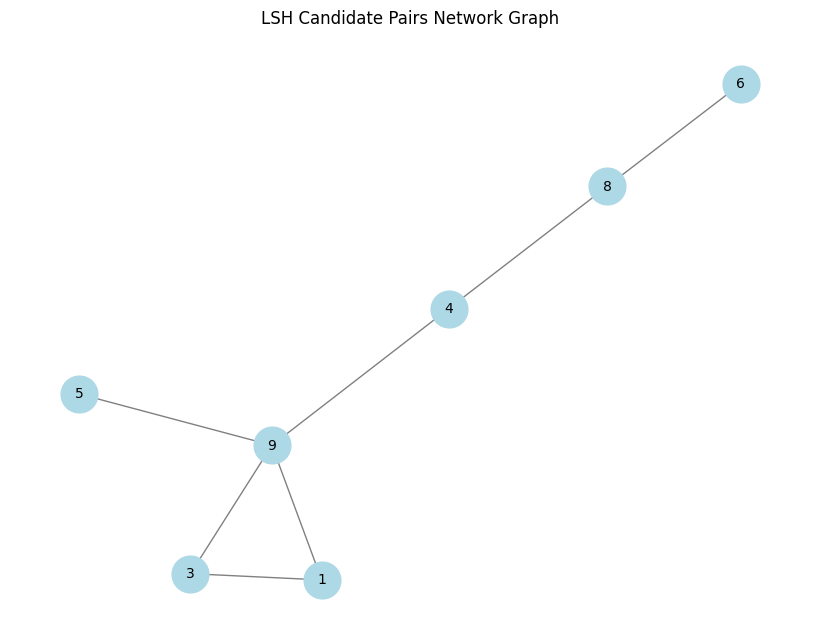

In [56]:
# Visualizing the similarities as a network graph

G = nx.Graph()
G.add_edges_from(candidate_pairs)

plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
plt.title('LSH Candidate Pairs Network Graph')
plt.show()


## Testing and Evaluation

For comparison, we can confront the results obtained with the Jaccard similarity with those obtained with the Signatuer Comparison (k=2 and n = 150 for the shingles and hash functions respectively). In addition to comparing their values, we can also examine which implementation is the quickest.

The time for computing the Jaccard similarity of 10 documents is 0.0028352737426757812


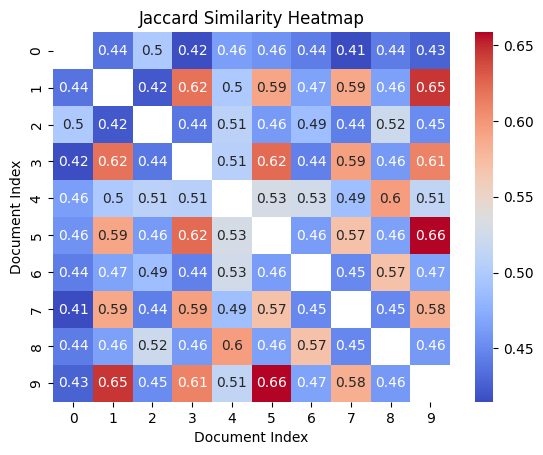

In [97]:
# Computing the Jaccard Similarity for the hashed k-shingles of the documents
similarity_matrix_1 = np.zeros((len(hashed_docs), len(hashed_docs)))

start = time.time()
for i in range(len(hashed_docs)):
    for j in range(i+1, len(hashed_docs)):
        similarity = comparer.jaccard_sim(hashed_docs[i], hashed_docs[j])
        similarity_matrix_1[i, j] = similarity
        similarity_matrix_1[j, i] = similarity
end = time.time()
time_js = (end - start)


print(f'The time for computing the Jaccard similarity of {len(hashed_docs)} documents is {time_js}')

# Visualizing in a heatmap

sns.heatmap(similarity_matrix_1, annot=True, cmap='coolwarm', mask=similarity_matrix_1 == 0)
plt.title('Jaccard Similarity Heatmap')
plt.xlabel('Document Index')
plt.ylabel('Document Index')
plt.show()

The time for computing the Jaccard similarity of 10 documents is 0.006785869598388672


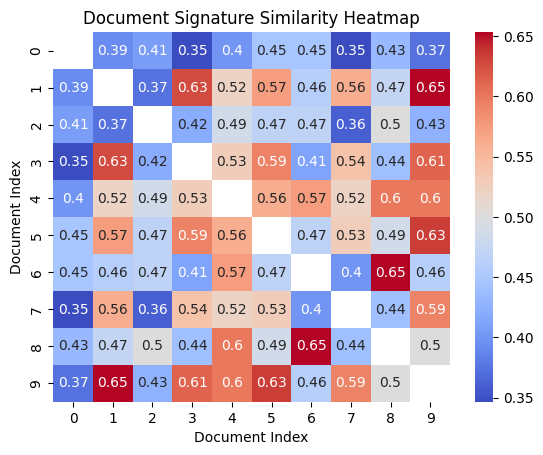

In [102]:
# Computing the signature similarity for the min-hashed documents

num_documents = signature_matrix.shape[1]
similarity_matrix_2 = np.zeros((num_documents, num_documents))

start = time.time()
for i in range(num_documents):
    for j in range(num_documents):
      similarity_matrix_2[i, j] = compare_signatures.similarity(signature_matrix[:, i], signature_matrix[:, j])
end = time.time()
time_ss = (end-start)
print(f'The time for computing the Jaccard similarity of {len(hashed_docs)} documents is {time_ss}')


# Visualizing in a heatmap

sns.heatmap(similarity_matrix_2, annot=True, cmap='coolwarm', mask=similarity_matrix_1 == 0)
plt.title('Document Signature Similarity Heatmap')
plt.xlabel('Document Index')
plt.ylabel('Document Index')
plt.show()


As we can see, the results do not differ much in terms of values, and the Jaccard similarity, for this particular implementation, results quicker than the min-hashed signature version for 10 textual documents.

We can further compare these results by defining a similarity threshold, in this case still t=0.6, and inspect which pairs are identified by both of them.

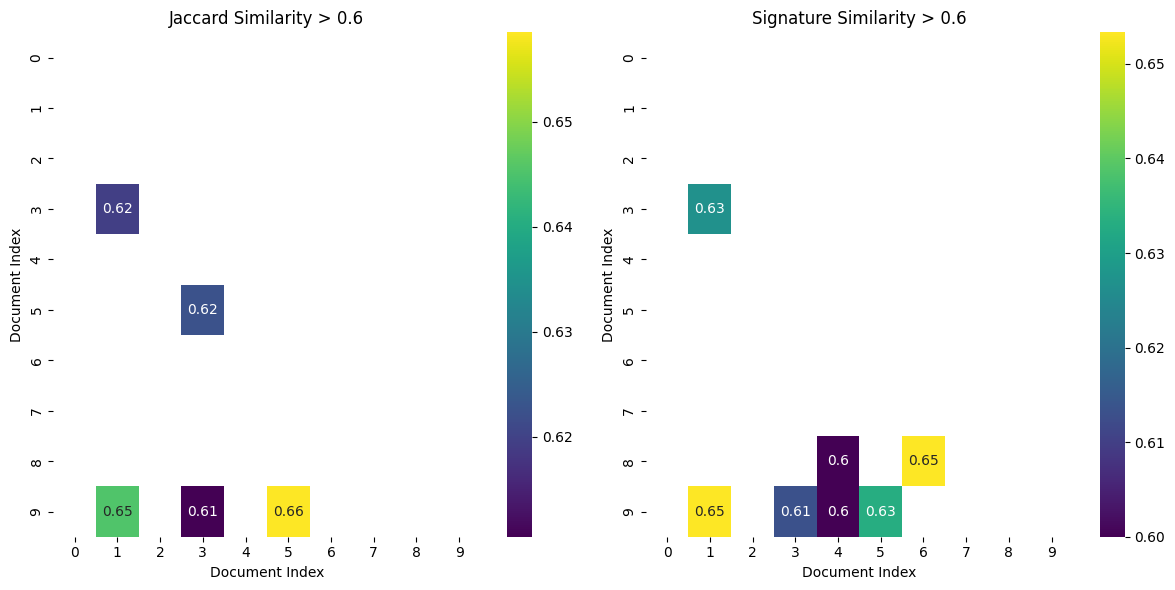

In [96]:

def plot_heatmap_with_threshold(matrix, threshold, ax, title):
    # Apply threshold: mask values below the threshold
    mask_thr = np.logical_or(matrix < threshold, np.triu(np.ones_like(matrix, dtype=bool)))
    sns.heatmap(matrix, mask=mask_thr, annot=True, cmap='viridis', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Document Index')
    ax.set_ylabel('Document Index')

# Assuming similarity_matrix1 and similarity_matrix2 are your similarity matrices
similarity_threshold = 0.6

# Create a figure with two subplots
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
plot_heatmap_with_threshold(similarity_matrix_1, similarity_threshold, ax1, 'Jaccard Similarity > 0.6')

ax2 = plt.subplot(1, 2, 2)
plot_heatmap_with_threshold(similarity_matrix_2, similarity_threshold, ax2, 'Signature Similarity > 0.6')

plt.tight_layout()
plt.show()


The pairs \{(1,9), (3,9), (5,9), (1,3)\} are scored as similar by both algorithms. This indicates that their similarity could be relevant and coherent.

## Comparing More Essays
We can extend the analysis to a dataset of 15 documents to compare how the results change. We will consider both the difference in time for execution and the difference in results.

The time for computing the Jaccard similarity of 15 documents is 0.005688190460205078
The time for computing the Signature similarity of 15 documents is 0.24434852600097656


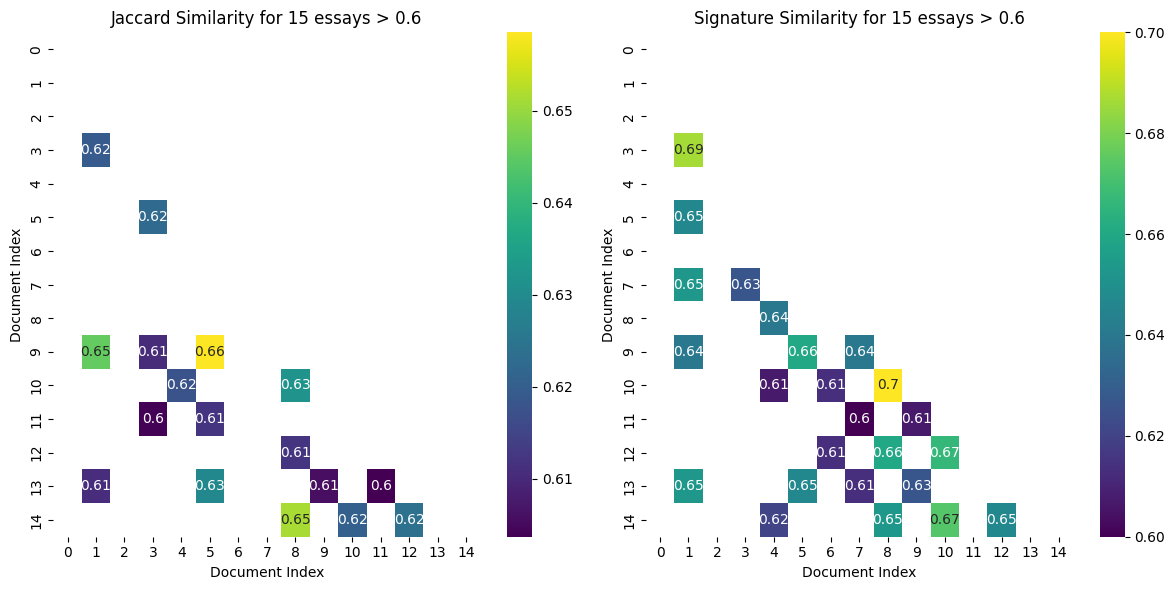

In [112]:
# Obtaining a dataset of 15 essays

df_2 = pd.read_csv('ielts_writing_dataset.csv')
df_2 = df_2.head(15)
hashed_docs_2 = [shingler.build_hash(doc, k=2) for doc in df_2['Essay']]
signature_matrix_2 = min_hash_instance.generate_minhash_signature(hashed_docs_2)

# Computing the Jaccard Similarity for the hashed k-shingles of the new documents
similarity_matrix_reduced_1 = np.zeros((len(hashed_docs_2), len(hashed_docs_2)))

start = time.time()
for i in range(len(hashed_docs_2)):
    for j in range(i+1, len(hashed_docs_2)):
        similarity = comparer.jaccard_sim(hashed_docs_2[i], hashed_docs_2[j])
        similarity_matrix_reduced_1[i, j] = similarity
        similarity_matrix_reduced_1[j, i] = similarity
end = time.time()
time_js = (end - start)

print(f'The time for computing the Jaccard similarity of {len(hashed_docs_2)} documents is {time_js}')

# Computing the Signature Similarity for the min-hashed new  documents

similarity_matrix_reduced_2 = np.zeros((len(hashed_docs_2), len(hashed_docs_2)))

start = time.time()
for i in range(len(hashed_docs_2)):
    for j in range(len(hashed_docs_2)):
      similarity_matrix_reduced_2[i, j] = compare_signatures.similarity(signature_matrix_2[:, i], signature_matrix_2[:, j])
end = time.time()
time_ss = (end-start) + time_ss
print(f'The time for computing the Signature similarity of {len(hashed_docs_2)} documents is {time_ss}')

similarity_threshold = 0.6

# Visualizing the heatmaps

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
plot_heatmap_with_threshold(similarity_matrix_reduced_1, similarity_threshold, ax1, 'Jaccard Similarity for 15 essays > 0.6')
ax2 = plt.subplot(1, 2, 2)
plot_heatmap_with_threshold(similarity_matrix_reduced_2, similarity_threshold, ax2, 'Signature Similarity for 15 essays > 0.6')
plt.tight_layout()
plt.show()

Increasing the number of documents from 10 to 15 could lead to more variation in the similarity results obtained from Jaccard similarity and signature-based methods. With more documents, there's likely to be a greater variety of content. This diversity can introduce more unique shingles and, consequently, more variability in how documents compare to each other. As the corpus size increases, the patterns of overlap between documents can become more complex, and this complexity might not be fully captured by the compressed representations used in MinHashing, and lead to collisions which might affect the accuracy of results. The hyperparameters considered in this work may need to be re-evaluated to better fit the new dataset.



## Conclusions

This project's primary objective was to implement stages of finding textually similar documents using Shingling, MinHashing, and Locality-Sensitive Hashing (LSH) techniques. The analysis was conducted on a dataset of IELTS Writing Scored Essays. The implementation was done in Python, and the results were visualized using heatmaps and network graphs.



1. **Shingling** provides a robust foundation for further similarity analysis. The decision on the shingle size (k) significantly affected the outcomes, with smaller k values leading to more granular comparison.
2. **Jaccard similarity** computation effectively highligs the degree of overlap between different document sets. The heatmaps served as an effective tool for visualizing these similarities, indicating clear patterns and relationships between the documents. A key observation was the variance in similarity scores, which depended significantly on the chosen k value for shingling.

3. **MinHashing** reduced the dimensionality of our data, making the computation of similarities more efficient while retaining a high degree of accuracy, considering an adequate number of hash functions.
4. **LSH** technique successfully identified candidate pairs of documents with high similarity. The network graph visualization revealed clusters of documents that shared significant similarities.
5. The execution time analysis showed that Jaccard similarity, especially with smaller datasets, leads to faster results. The similarity scores result close when the number of considered essays is n=10, while they show substantial differences with a dataset of n=15 documents.

